# DETR 系列算法: 从原型到SOTA
**原理 · 实验 · 实战**  
AI Tech Sharing · 2025-05-29  
<div style="text-align:right;font-size:32px">Speaker: Rookie</div>

---

In [74]:
import os
import warnings
from typing import Optional, List

import math
import copy

import torch  
import torch.nn as nn  
from torch import Tensor
import torch.nn.functional as F
import torchvision.models as models 
from torchsummary import summary

warnings.filterwarnings("ignore", category=UserWarning)

import utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


## 议程
1. 背景与动机  
2. 原始 DETR  
3. Deformable DETR  
4. 轻量级 / 快速变体  
5. SOTA 算法与基准测试  
6. 可视化与演示  
7. 技巧与未来工作

<img src="./imgs/DETR.png.png" style="width:100%;border:none"/>

## 1 · 背景与动机  
<small>Why another detector?</small>  

### 1.1 经典目标检测两条路线  
<br/><br/>
| Two-Stage | One-Stage |  
|-----------|-----------|  
| **Faster R-CNN** <br/>· RPN 产生候选框 <br/>· RoIAlign → 分类/回归 | **YOLO / SSD** <br/>· 直接在特征图上回归类别 + 坐标 |  
| 优：精度高，易插拔 | 优：速度快，端到端训练 | 

#### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;共通流程  
<div style="display:flex;gap:24px">  
  <ul style="font-size:95%; padding-left:800px">  
    <li>CNN 提取特征</li>  
    <li><b>Anchor</b>：预定义框网格</li>  
    <li>分类 + 回归两头训练</li>  
    <li>推理时靠 <b>NMS</b> 去重</li>  
  </ul>  
</div>  


### 1.2 传统方法的痛点  

* 需要大量 **Anchor / IoU / NMS** 超参  
* 多阶段或多任务损失，**端到端不可微**  
* CNN 局部感受野 → **遮挡、长距依赖** 处理差  
* 代码与推理路径复杂，迁移到新领域要 **重新调参**  


#### 超参数依赖性问题
传统检测框架普遍依赖大量人工设定的超参数，包括Anchor尺度与比例、IoU阈值以及NMS抑制参数等。这种高度参数化的设计不仅增加了模型调优的复杂度，更重要的是限制了模型的泛化能力和自适应性。参数敏感性使得模型在面对不同数据分布时需要重新进行繁琐的超参数搜索。

#### 端到端优化障碍
多阶段检测流程和多任务损失函数的设计虽然在一定程度上提升了检测精度，但破坏了端到端训练的连续性。非可微分的后处理步骤阻断了梯度的有效传播，导致整体优化过程次优，无法实现全局最优解。

#### 空间建模局限性
卷积神经网络的局部感受野特性在处理目标遮挡和长距离空间依赖关系时表现不佳。这种局限性在复杂场景中尤为突出，影响了模型对全局上下文信息的有效利用和目标间关系的准确建模。

### 1.3 DETR 的颠覆性思路  
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr_pipline.png" style="width:100%; display:block;">  
    </div>  
    
<div style="flex:0 0 65%;">  
        <ul style="font-size:95%; margin:0; padding-left:500px; padding-top:200px">  
            <li><b>Set Prediction</b>：把检测视作「图片 → 对象集合」</li>  
            <li><b>Transformer</b> 全局自注意力，消除局部瓶颈</li>  
            <li>二分图匹配(匈牙利匹配算法) → 天然去掉 NMS</li>  
            <li>固定长度 Query → 无需 Anchor</li>  
            <li>单损失端到端，简化训练与部署</li>  
        </ul>  
    </div>  
</div>  

## 2 · 原始 DETR
- **架构**：Backbone → Transformer Encoder/Decoder → FFN  
- **对象查询 (Object Queries)**  
- **集合损失 & 匈牙利匹配**  

![](./imgs/DETR.png.png)


### 2.1 网络结构 

#### 2.1.1 CNN Backbone

###### 架构概述
原始DETR采用在ImageNet上预训练的ResNet作为特征提取骨干网络。经过backbone处理后，输入图像的特征表示发生如下变化：
- **输出通道数**：增至2048维
- **空间分辨率**：降采样至原始尺寸的1/32

##### 设计考量
选择CNN作为backbone的设计考量主要基于以下两个关键因素：
1. 特征层次性匹配: 早期的低级视觉特征（如边缘、纹理等）通常具有较强的局部性特点，长程空间依赖关系相对较弱。CNN的局部感受野和层次化特征提取机制能够高效捕捉这类特征模式。
2. 计算效率优势：相比于完全基于Transformer编码器的纯视觉检测器，CNN backbone在处理低级特征时具有更高的计算效率，能够在保证特征质量的同时显著降低整体模型的计算复杂度。


#### 代码: Backbone 主干网络

In [103]:
class ResNetBackbone(nn.Module):  
    """ResNet主干网络"""  
    def __init__(self, hidden_dim=256, pretrained=True):  
        super().__init__()  
        self.hidden_dim = hidden_dim  
        # 加载预训练ResNet50  
        resnet = models.resnet50(pretrained=pretrained)  
        # 去掉最后的全局池化和分类层  
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  
        # 1x1卷积调整通道数：2048 -> hidden_dim  
        self.conv_proj = nn.Conv2d(2048, hidden_dim, kernel_size=1)  
        # 可选：冻结早期层参数  
        self._freeze_early_layers()  
        
    def _freeze_early_layers(self, freeze_at=2):  
        """冻结前几个stage的参数"""  
        for name, param in self.backbone.named_parameters():  
            if any(f'layer{i}' in name for i in range(freeze_at)):  
                param.requires_grad = False  
                
    def forward(self, x):  
        """  
        输入: [bs, 3, H, W]  
        输出: [bs, hidden_dim, H//32, W//32]  
        """  
        features = self.backbone(x)      # [bs, 2048, H//32, W//32]  
        features = self.conv_proj(features)  # [bs, hidden_dim, H//32, W//32]  
        return features  


In [105]:
backbone = ResNetBackbone(hidden_dim=256).to(device)  
x = torch.randn(1, 3, 800, 800).to(device)  
features = backbone(x)  
print(x.shape, features.shape)
summary(backbone, input_size=(3, 800, 800))

torch.Size([1, 3, 800, 800]) torch.Size([1, 256, 25, 25])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           9,408
       BatchNorm2d-2         [-1, 64, 400, 400]             128
              ReLU-3         [-1, 64, 400, 400]               0
         MaxPool2d-4         [-1, 64, 200, 200]               0
            Conv2d-5         [-1, 64, 200, 200]           4,096
       BatchNorm2d-6         [-1, 64, 200, 200]             128
              ReLU-7         [-1, 64, 200, 200]               0
            Conv2d-8         [-1, 64, 200, 200]          36,864
       BatchNorm2d-9         [-1, 64, 200, 200]             128
             ReLU-10         [-1, 64, 200, 200]               0
           Conv2d-11        [-1, 256, 200, 200]          16,384
      BatchNorm2d-12        [-1, 256, 200, 200]             512
           Conv2d-13        [-1, 256, 200, 20

#### 2.1.2  Transformer Encoder
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-encode.png" style="width:100%; display:block;">  
    </div>  
 <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>特征预处理</h4>
            <ul>
                <li><strong>降维操作</strong>：由于ResNet输出的通道数 $C=2048$ 维度较高，首先通过 $1 \times 1$ 卷积将特征维度降至256或512，以减少计算复杂度并提升训练效率</li>
                <li><strong>维度重构</strong>：将特征图从 $C \times H \times W$ reshape为 $HW \times C$ 的序列格式</li>
            </ul>
        </div>
</div>


#### 2.1.2 Transformer Encoder

<table width="100%">
<tr>
<td width="30%" valign="top" align="left">
    <img src="./imgs/detr-encode.png" width="100%">
</td>
<td width="70%" valign="top" align="left">

<h4>位置编码机制</h4>
<ul>
    <li><strong>注入策略</strong>：位置编码在每个Multi-Head Self-Attention层前都会被加入，确保位置信息在整个编码过程中得到充分利用</li>
    <li><strong>2D编码设计</strong>：针对图像的二维特性，分别计算x和y维度的正弦/余弦位置编码，然后拼接形成最终的位置表示</li>
</ul>

<div style="height:500px; overflow-y:auto; border:1px solid #ccc; padding:10px; text-align:left;">
<blockquote style="text-align:left;">
<h4>📍 位置编码数学公式</h4>

<h5>1. 注入策略公式</h5>
<div align="center">
<strong>每层输入 = 特征 + 位置编码</strong><br>
X<sub>l</sub> = X<sub>l-1</sub> + PE<sub>2D</sub><br>
其中 l = 1, 2, ..., L (L为编码器层数)
</div>

<h5>2. 一维位置编码基础公式</h5>
<div align="center">
PE(pos, 2i) = sin(pos / 10000<sup>2i/d</sup>)<br>
PE(pos, 2i+1) = cos(pos / 10000<sup>2i/d</sup>)
</div>
<ul>
    <li><code>pos</code>: 位置索引</li>
    <li><code>i</code>: 维度索引 (0 ≤ i < d/2)</li>
    <li><code>d</code>: 编码维度</li>
</ul>

<h5>3. 二维位置编码扩展公式</h5>

<p><strong>X维度编码：</strong></p>
<div align="center">
PE<sub>x</sub>(x, 2i) = sin(x / 10000<sup>2i/d<sub>x</sub></sup>)<br>
PE<sub>x</sub>(x, 2i+1) = cos(x / 10000<sup>2i/d<sub>x</sub></sup>)
</div>

<p><strong>Y维度编码：</strong></p>
<div align="center">
PE<sub>y</sub>(y, 2j) = sin(y / 10000<sup>2j/d<sub>y</sub></sup>)<br>
PE<sub>y</sub>(y, 2j+1) = cos(y / 10000<sup>2j/d<sub>y</sub></sup>)
</div>

<p><strong>拼接形成最终编码：</strong></p>
<div align="center">
PE<sub>2D</sub>(x,y) = <em>Concat</em>[PE<sub>x</sub>(x), PE<sub>y</sub>(y)]<br>
维度: PE<sub>2D</sub> ∈ ℝ<sup>H×W×D</sup><br>
其中 d<sub>x</sub> + d<sub>y</sub> = D, 通常 d<sub>x</sub> = d<sub>y</sub> = D/2
</div>

<h5>4. 完整计算流程</h5>
<ol>
    <li><strong>特征图展平:</strong> X<sub>flat</sub> ∈ ℝ<sup>N×D</sup>, N = H×W</li>
    <li><strong>生成2D位置编码:</strong> PE<sub>2D</sub> ∈ ℝ<sup>N×D</sup></li>
    <li><strong>逐层注入:</strong> X<sub>l</sub> = X<sub>l-1</sub> + PE<sub>2D</sub></li>
    <li><strong>自注意力计算:</strong> Z<sub>l</sub> = MultiHead(X<sub>l</sub>, X<sub>l</sub>, X<sub>l</sub>)</li>
    <li><strong>残差连接:</strong> Output<sub>l</sub> = LayerNorm(X<sub>l</sub> + Z<sub>l</sub>)</li>
</ol>

<h5>5. 关键参数</h5>
<ul>
    <li><strong>H, W</strong>: 特征图高度和宽度</li>
    <li><strong>D</strong>: 位置编码总维度 (与特征维度相同)</li>
    <li><strong>x ∈ [0, W-1], y ∈ [0, H-1]</strong>: 像素坐标</li>
    <li><strong>10000</strong>: 固定的温度参数，控制编码频率</li>
</ul>

</blockquote>
</div>

</td>
</tr>
</table>

#### 2.1.2 Transformer Encoder
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-encode.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>全局关系建模</h4>
            <p>自注意力机制在重构后的特征序列上执行全局分析，这一设计具有以下优势：</p>
            <ul>
                <li><strong>大目标优势</strong>：最后一层特征图的感受野较大，对大物体检测友好</li>
                <li><strong>语义关联学习</strong>：Self-Attention能够捕捉不同空间位置间的长程依赖关系，学习对象间的共现模式（如桌子与杯子、草坪与树木的空间关联）</li>
                <li><strong>性能提升</strong>：这正是DETR在大目标检测上优于Faster R-CNN的核心原因</li>
            </ul>
        </div>
    </div>
</div>

##### 代码实现: 位置编码 (Position Encoding)

In [53]:
class PositionEmbeddingSine(nn.Module):  
    """
    正弦位置编码模块
    实现2D正弦位置编码，为图像的每个像素位置生成唯一的位置表示
    """  
    def __init__(self, hidden_dim=256, temperature=10000, scale=None):  
        super().__init__()  
        self.hidden_dim = hidden_dim              # 位置编码总维度
        self.num_pos_feats = hidden_dim // 2      # 一半给x维度，一半给y维度  
        self.temperature = temperature            # 温度参数，控制编码频率
        self.scale = 2 * math.pi if scale is None else scale  # 归一化尺度，默认2π
        
    def forward(self, x):  
        """  
        前向传播：为输入特征图生成2D位置编码
        
        Args:
            x: 输入特征图 [batch_size, hidden_dim, H, W]  
            
        Returns: 
            pos: 位置编码 [batch_size, hidden_dim, H, W]  
        """  
        bs, _, h, w = x.shape  
        device = x.device  
        # 步骤1: 生成位置索引坐标
        y_embed = torch.arange(h, dtype=torch.float32, device=device) # y_embed: [0, 1, 2, ..., h-1] 表示每一行的索引  
        x_embed = torch.arange(w, dtype=torch.float32, device=device)  # x_embed: [0, 1, 2, ..., w-1] 表示每一列的索引      
        # 步骤2: 归一化位置坐标到[0, 2π]范围
        y_embed = y_embed / h * self.scale  # 将像素坐标从[0, h-1]映射到[0, 2π]
        x_embed = x_embed / w * self.scale  # 将像素坐标从[0, w-1]映射到[0, 2π]
        # 步骤3: 生成频率序列
        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=device) # dim_t: [0, 1, 2, ..., num_pos_feats-1]  
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)  # 计算频率: temperature^(2i/d) 其中i为维度索引
        # 步骤4: 计算位置编码
        pos_x = x_embed[:, None] / dim_t  # pos_x: [W, num_pos_feats] 每列的x维度位置编码 
        pos_y = y_embed[:, None] / dim_t  # pos_y: [H, num_pos_feats] 每行的y维度位置编码
        # 步骤5: 应用正弦余弦函数并交替排列
        pos_x = torch.stack([pos_x[:, 0::2].sin(), pos_x[:, 1::2].cos()], dim=2).flatten(1)  # 偶数索引用sin，奇数索引用cos，然后展平
        pos_y = torch.stack([pos_y[:, 0::2].sin(), pos_y[:, 1::2].cos()], dim=2).flatten(1)  
        # 步骤6: 扩展到2D网格
        pos_y = pos_y[:, None, :].expand(-1, w, -1)  # pos_y: [H, W, num_pos_feats] 将每行的y编码复制到所有列
        pos_x = pos_x[None, :, :].expand(h, -1, -1)  # pos_x: [H, W, num_pos_feats] 将每列的x编码复制到所有行
        # 步骤7: 拼接x和y维度的位置编码
        pos = torch.cat([pos_y, pos_x], dim=-1)  # pos: [H, W, hidden_dim] 完整的2D位置编码
        # 步骤8: 调整维度顺序并扩展batch维度
        pos = pos.permute(2, 0, 1).unsqueeze(0).expand(bs, -1, -1, -1)  # 从[H, W, hidden_dim]转为[hidden_dim, H, W]，然后扩展到batch_size
        
        return pos

In [46]:
pos_encoder = PositionEmbeddingSine(hidden_dim=256)  
features = torch.randn(2, 256, 25, 25)  
pos_embed = pos_encoder(features)  
print(f"特征: {features.shape}")  
print(f"位置编码: {pos_embed.shape}")  # [2, 256, 25, 25]  

特征: torch.Size([2, 256, 25, 25])
位置编码: torch.Size([2, 256, 25, 25])


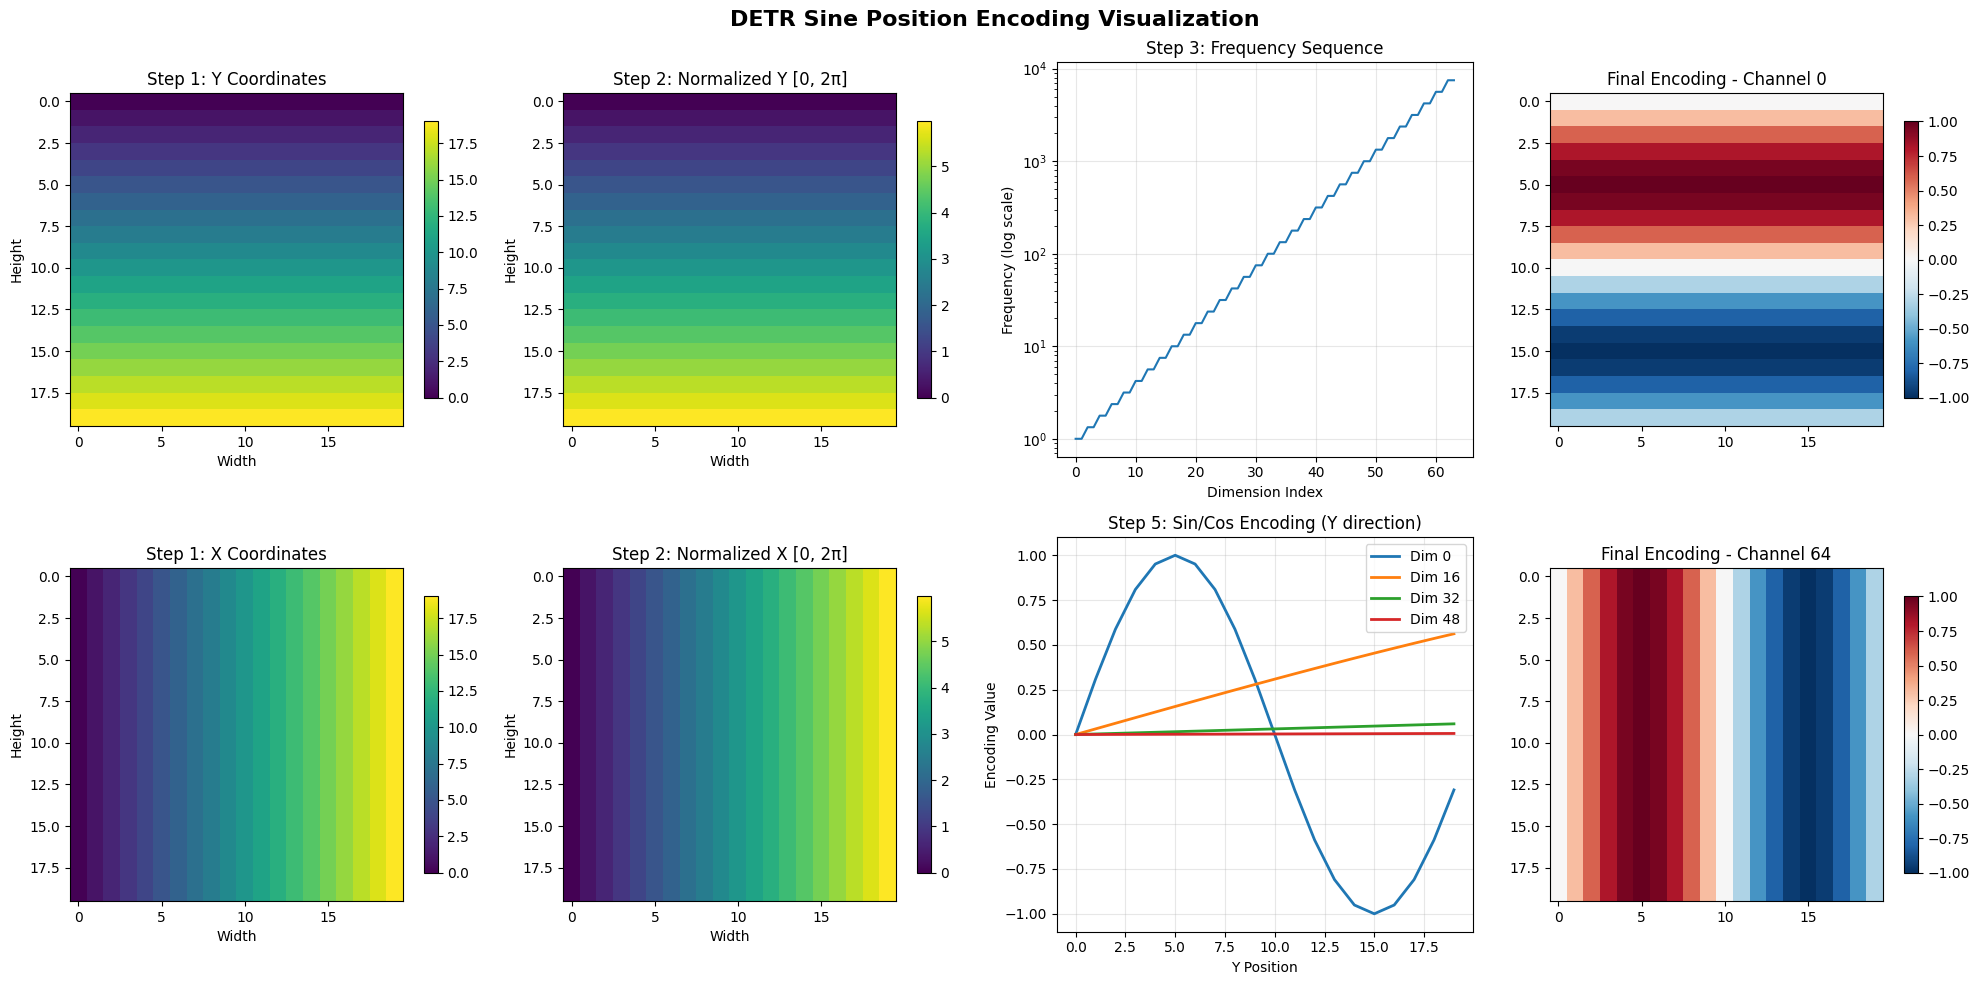

Sine Position Encoding Analysis
Input shape: torch.Size([1, 128, 20, 20])
Output shape: torch.Size([128, 20, 20])
Hidden dim: 128
Num pos feats: 64
Temperature: 10000
Scale: 6.2832
Encoding range: [-1.0000, 1.0000]


In [48]:
utils.visualize_sine_position_encoding()  

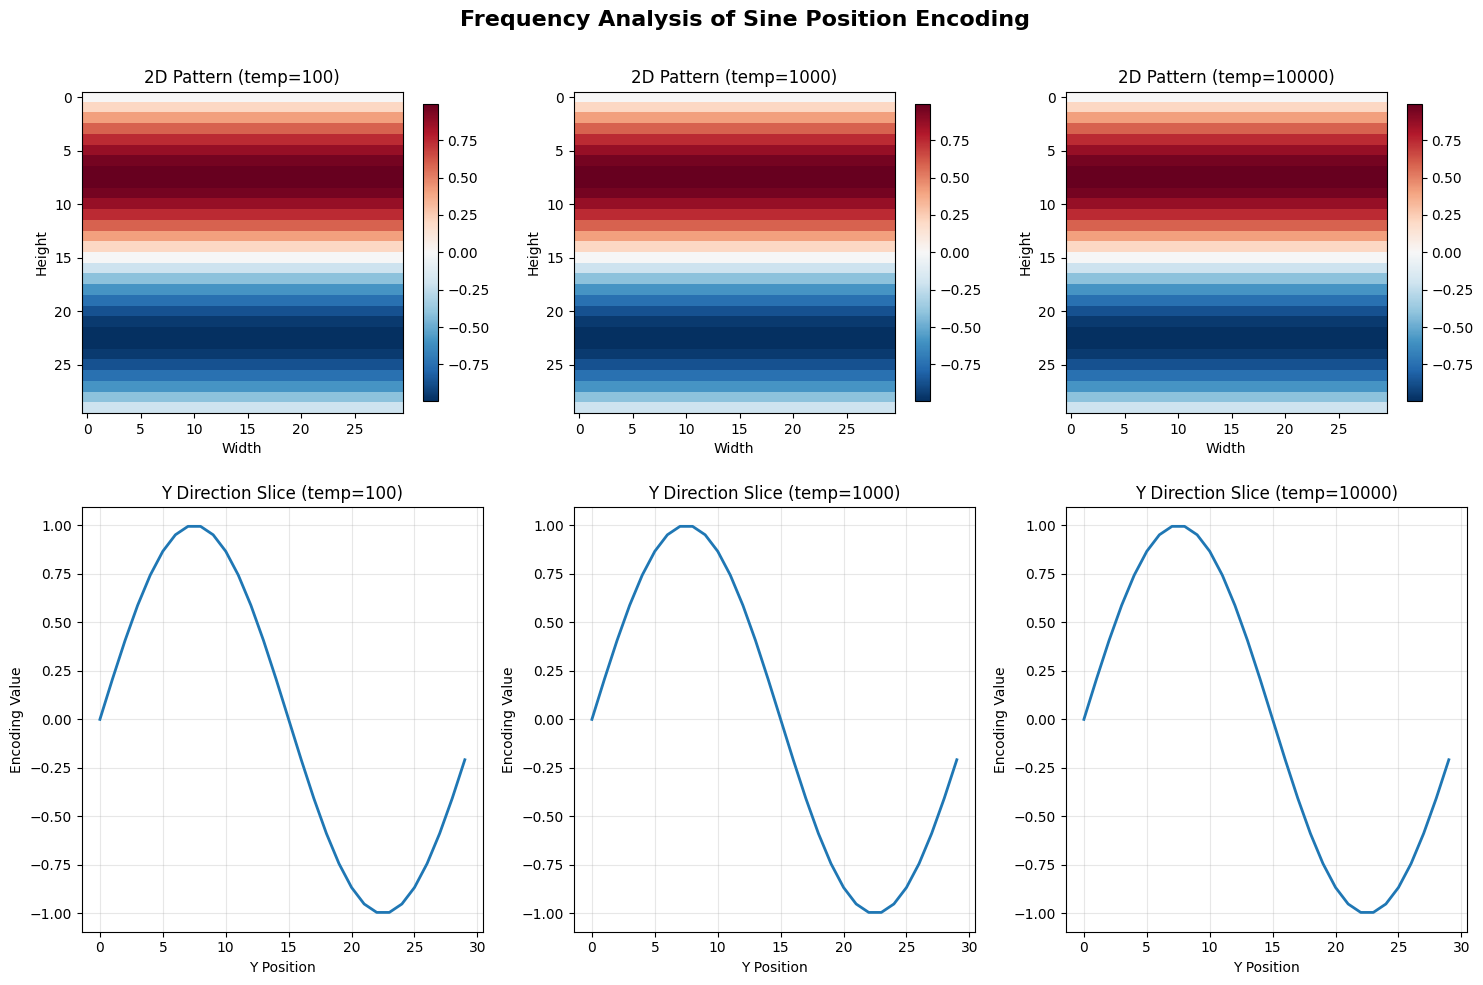

In [49]:
# 频率分析  
utils.visualize_frequency_analysis()  

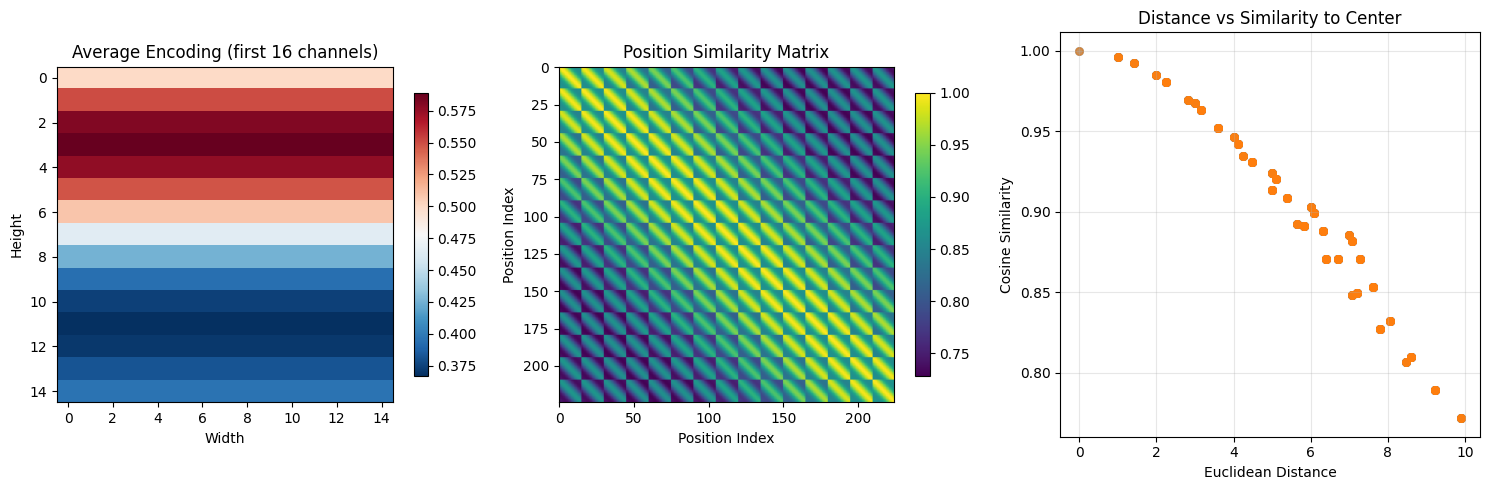

Position Encoding Uniqueness Analysis
Total positions: 225
Encoding dimension: 64
Average similarity: 0.8672
Min similarity: 0.7278
Max similarity: 1.0000
Self-similarity (should be 1.0): 1.0000 ± 0.0000


In [50]:
# 唯一性分析  
utils.visualize_encoding_uniqueness()

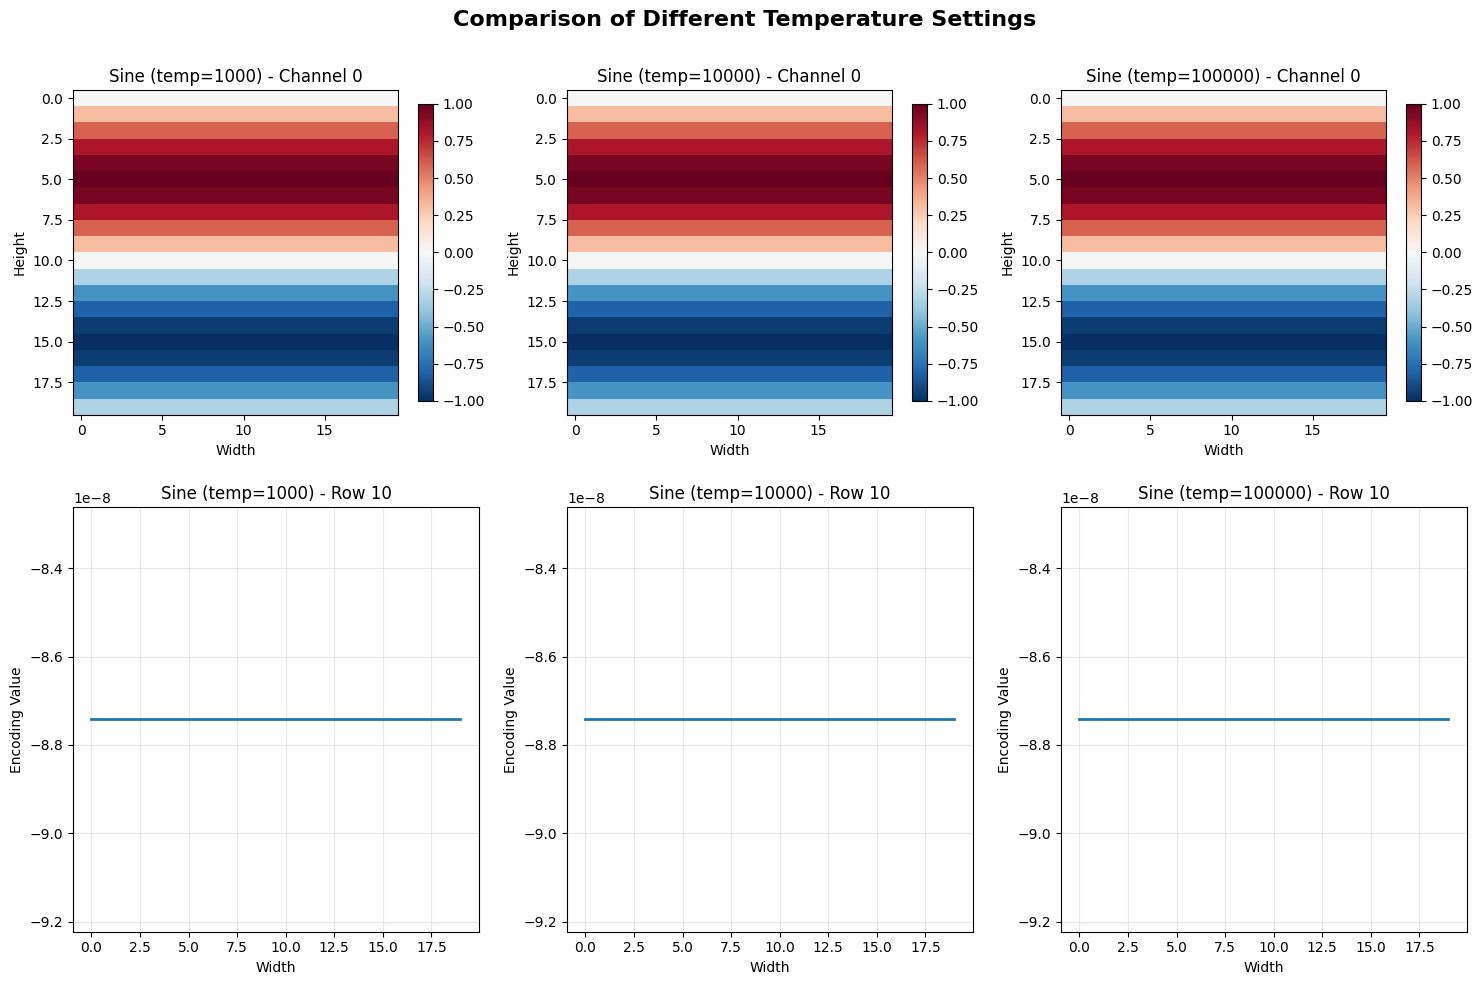

In [52]:
# 不同参数比较  
utils.compare_encoding_methods() 

##### 代码实现: Encode

In [92]:
class TransformerEncoderLayer(nn.Module):
    """
    Transformer编码器层。
    包含自注意力层和前馈网络。
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation=F.relu, normalize_before=False):
        """
        初始化编码器层。
        参数:
            d_model: 模型维度
            nhead: 注意力头数
            dim_feedforward: 前馈网络维度,默认2048
            dropout: dropout率,默认0.1
            activation: 激活函数,默认"relu"
            normalize_before: 是否在前进行归一化,默认False
        """
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # 前馈网络实现
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = activation
        self.normalize_before = normalize_before    # 是否在前进行归一化

    def with_pos_embed(self, tensor, pos: Optional[torch.Tensor]):
        """
        将位置编码加到输入张量上
        """
        return tensor if pos is None else tensor + pos

    def forward_post(self,
                     src,
                     src_mask: Optional[torch.Tensor] = None,
                     src_key_padding_mask: Optional[torch.Tensor] = None,
                     pos: Optional[torch.Tensor] = None):
        """
        后归一化的前向传播
        """
        q = k = self.with_pos_embed(src, pos)
        src2 = self.self_attn(q, k, value=src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

    def forward(self, src,
                src_mask: Optional[torch.Tensor] = None,
                src_key_padding_mask: Optional[torch.Tensor] = None,
                pos: Optional[torch.Tensor] = None):
        return self.forward_post(src, src_mask, src_key_padding_mask, pos)


> 不同于标准Transformer Encode 的地方: value 并没有加入位置编码 

In [94]:
class TransformerEncoder(nn.Module):
    """
    Transformer编码器。
    由多个编码器层堆叠而成。
    """
    def __init__(self, encoder_layer, num_layers, norm=None):
        """
        初始化编码器。
        
        参数:
            encoder_layer: 单个编码器层
            num_layers: 编码器层数
            norm: 归一化层,默认None
        """
        super().__init__()
        self.layers =  nn.ModuleList([copy.deepcopy(encoder_layer) for i in range(num_layers)])
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        """
        前向传播函数。
        
        参数:
            src: 输入序列  [seq_len, batch_size, d_model]
                 - seq_len: 序列长度，对于图像为H*W (特征图展平后的长度)
                 - batch_size: 批次大小
                 - d_model: 特征维度 (如512)
                 例如: [100, 32, 512] 表示10x10特征图，batch=32，特征维度512
            mask: 注意力mask
            src_key_padding_mask: key padding mask
            pos: 位置编码
            
        返回:
            output: 编码器输出
        """
        output = src

        # 依次通过每个编码器层
        for layer in self.layers:
            output = layer(output, src_mask=mask,
                           src_key_padding_mask=src_key_padding_mask, pos=pos)

        if self.norm is not None:
            output = self.norm(output)

        return output


> 相较于标准Transformer, DETR编码器中的每个EncoderLayer都加入了位置编码

In [91]:
# 构建编码器层
encoder_layer = TransformerEncoderLayer(
    d_model=256,        # 模型维度/特征维度
    nhead=8,           # 多头注意力的头数
    dim_feedforward=2048,  # 前馈网络的隐藏层维度
    dropout=0.1,       # dropout概率
    activation=F.relu, # 激活函数
)

# 构建完整编码器（堆叠6层）
encoder = TransformerEncoder(
    encoder_layer,  # 编码器层
    num_layers=6,   # 堆叠层数
)

# 模型结构总览
# 注意：TransformerEncoder期望输入格式为 (sequence_length, batch_size, d_model)
x = encoder(features.flatten(2).permute(2, 0, 1))   # [HW, N, C])
features.shape, x.shape

(torch.Size([2, 256, 25, 25]), torch.Size([625, 2, 256]))

#### 2.1.3 Transformer Decoder
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-decode.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>位置编码与并行解码</h4>
            <ul>
                <li><strong>Object Query设计</strong>：与ViT不同，DETR的Decoder引入位置编码作为可学习的Object Query，使不同查询对应图像中不同位置，实现空间感知的目标检测</li>
                <li><strong>编码注入策略</strong>：位置编码同时添加到Encoder的key和Decoder每一层的query中，确保位置信息在整个解码过程中得到充分利用</li>
                <li><strong>并行解码机制</strong>：摒弃自回归模式，采用并行解码N个对象，通过自注意力和编码器-解码器注意力实现全局推理，平衡计算成本与检测性能</li>
                <li><strong>深监督学习</strong>：每个Decoder层的输出都通过参数共享的FFN进行预测并计算loss，实现多层级监督训练</li>
            </ul>
        </div>
    </div>
</div>

##### 代码实现: Decoder Layer
###### 1.类定义和初始化

In [98]:
class TransformerDecoderLayer(nn.Module):  
    """  
    Transformer解码器层。  
    包含自注意力层、交叉注意力层和前馈网络。  
    """  
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,  
                 activation=F.relu, normalize_before=False):  
        """  
        初始化解码器层。  
        
        参数:  
            d_model: 模型维度  
            nhead: 注意力头数  
            dim_feedforward: 前馈网络维度,默认2048  
            dropout: dropout率,默认0.1  
            activation: 激活函数,默认"relu"  
            normalize_before: 是否在前进行归一化,默认False  
        """  
        super().__init__()  
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout) # 自注意力层  
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout) # 交叉注意力层  
        # 前馈网络实现  
        self.linear1 = nn.Linear(d_model, dim_feedforward) # 线性层1  
        self.dropout = nn.Dropout(dropout)  
        self.linear2 = nn.Linear(dim_feedforward, d_model) # 线性层2  

        self.norm1 = nn.LayerNorm(d_model) # 归一化层1  
        self.norm2 = nn.LayerNorm(d_model) # 归一化层2  
        self.norm3 = nn.LayerNorm(d_model) # 归一化层3  
        self.dropout1 = nn.Dropout(dropout) # 丢弃层1  
        self.dropout2 = nn.Dropout(dropout) # 丢弃层2  
        self.dropout3 = nn.Dropout(dropout) # 丢弃层3  

        self.activation = activation  
        self.normalize_before = normalize_before 

##### 2. forword 函数

In [101]:
def with_pos_embed(tensor, pos: Optional[Tensor]):  
    """将位置编码加到输入张量上"""  
    return tensor if pos is None else tensor + pos

def forward_post(self, tgt, memory,  
                 tgt_mask: Optional[Tensor] = None,  
                 memory_mask: Optional[Tensor] = None,  
                 tgt_key_padding_mask: Optional[Tensor] = None,  
                 memory_key_padding_mask: Optional[Tensor] = None,  
                 pos: Optional[Tensor] = None,  
                 query_pos: Optional[Tensor] = None):  
    """  
    后归一化的前向传播  

    参数:  
        tgt: 目标序列  
        memory: 编码器输出的memory  
        tgt_mask: 目标序列的注意力mask  
        memory_mask: memory的注意力mask  
        tgt_key_padding_mask: 目标序列的key padding mask  
        memory_key_padding_mask: memory的key padding mask  
        pos: 位置编码  
        query_pos: 查询位置编码  
    """  
    q = k = self.with_pos_embed(tgt, query_pos)  # 位置编码  
    tgt2 = self.self_attn(q, k, value=tgt, attn_mask=tgt_mask,  
                          key_padding_mask=tgt_key_padding_mask)[0]  # 自注意力层  
    tgt = tgt + self.dropout1(tgt2)  
    tgt = self.norm1(tgt)  
    tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),  
                               key=self.with_pos_embed(memory, pos),  
                               value=memory, attn_mask=memory_mask,  
                               key_padding_mask=memory_key_padding_mask)[0]  # 交叉注意力层  
    tgt = tgt + self.dropout2(tgt2)  # 丢弃层2  
    tgt = self.norm2(tgt)  # 归一化层2  
    tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))  # 线性层2  
    tgt = tgt + self.dropout3(tgt2)  # 丢弃层3  
    tgt = self.norm3(tgt)  # 归一化层3  
    return tgt


TransformerDecoderLayer.with_pos_embed = staticmethod(with_pos_embed)  
TransformerDecoderLayer.forward = forward_post

##### 3. 测试

In [102]:
# 创建测试实例  
d_model = 256  
nhead = 8  
decoder_layer = TransformerDecoderLayer(d_model, nhead)  

# 测试数据  
batch_size = 2  
tgt_len = 10  
memory_len = 20  

tgt = torch.randn(tgt_len, batch_size, d_model)  
memory = torch.randn(memory_len, batch_size, d_model)  
pos = torch.randn(memory_len, batch_size, d_model)  
query_pos = torch.randn(tgt_len, batch_size, d_model)  

# 前向传播测试  
output = decoder_layer(tgt, memory, pos=pos, query_pos=query_pos)  
print(f"✅ 测试通过! 输出形状: {output.shape}")  
print(f"预期形状: ({tgt_len}, {batch_size}, {d_model})")  

✅ 测试通过! 输出形状: torch.Size([10, 2, 256])
预期形状: (10, 2, 256)


#### 2.1.4 Prediction Feed-forward Networks
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-head.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>预测网络设计</h4>
            <ul>
                <li><strong>网络结构</strong>：采用3层感知机，配备ReLU激活函数，隐藏维度为d，通过线性投影层输出最终预测结果</li>
                <li><strong>边界框预测</strong>：FFN预测相对于输入图像的归一化边界框坐标（中心点、高度、宽度），确保预测结果的尺度不变性</li>
                <li><strong>类别预测</strong>：线性层通过softmax函数预测类别标签，引入特殊的"∅"类别标识未检测到对象的位置，类似传统方法中的"背景"类别</li>
                <li><strong>固定输出</strong>：由于预测固定的N个边界框（N通常远大于实际目标数量），"∅"类别有效处理空预测槽位</li>
            </ul>
        </div>
    </div>
</div>

### 2.2  损失函数  
$$\underset{\sigma \in \mathfrak{S}_N}{\arg\min}\;\sum_{i=1}^{N} \bigl[\lambda_{cls}\,\ell_{CE}(p_{\sigma(i)}, y_i) + \lambda_{box}\,\lVert b_{\sigma(i)} - \hat{b}_i\rVert_1 + \lambda_{iou}(1-\text{IoU}(b_{\sigma(i)}, \hat{b}_i)) \bigr]$$  
匈牙利算法求解 $\sigma$。

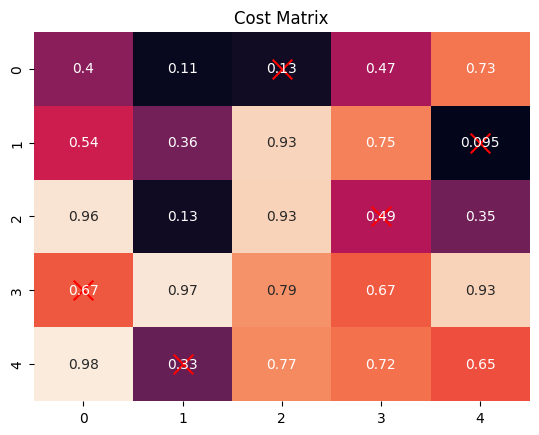

Optimal assignment cost: 1.7178800977845072


In [3]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
cost = np.random.rand(5,5)
row, col = linear_sum_assignment(cost)
sns.heatmap(cost, annot=True, cbar=False)
plt.title("Cost Matrix");plt.scatter(col+.5, row+.5, marker="x", s=200, c="red");plt.show()
print("Optimal assignment cost:", cost[row, col].sum())

### 2.3  瓶颈分析

#### 2.3.1 收敛速度问题
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-head.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>根本原因分析</h4>
            <ul>
                <li><strong>二分图匹配不稳定性</strong>：Hungarian匹配算法在训练初期存在极大不稳定性，预测与真值的匹配关系混乱，导致梯度传播不一致，学习过程缓慢</li>
                <li><strong>Object Query缺乏先验</strong>：目标查询初始状态缺乏空间位置先验，查询间分工不明确，需要从零学习如何关联图像中的具体目标，造成训练低效</li>
            </ul>
        </div>
    </div>
</div>

#### 2.3.2 小目标检测缺陷
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-encode.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>信息稀释机制</h4>
            <ul>
                <li><strong>全局注意力稀释</strong>：小目标在整个特征图中占比极小，Self-Attention计算中其query与大量背景位置产生弱相关，注意力权重被稀释分散，难以获得足够的特征表示</li>
                <li><strong>单尺度限制</strong>：仅使用C5特征图缺乏多尺度信息融合能力，O(N²)的注意力复杂度限制了高分辨率特征的利用，进一步削弱了小目标的检测性能</li>
            </ul>
        </div>
    </div>
</div>

#### 2.3.3 位置编码局限性
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;"> <div style="flex:0 0 30%;"> <img src="./imgs/detr-encode.png" style="width:100%; display:block;"> </div> <div class="container"> <div class="content-block" style="flex:0 0 65%;"> <h4>编码设计缺陷</h4> <ul> <li><strong>绝对编码局限</strong>：使用绝对位置编码，与具体图像尺寸强耦合，难以适应不同分辨率输入</li> <li><strong>空间先验缺失</strong>：Object Query通过随机初始化建模空间信息，与边界框的关联较弱</li> <li><strong>泛化能力差</strong>：训练时的位置编码模式难以迁移到不同尺寸和宽高比的测试图像</li> <li><strong>相对关系缺失</strong>：缺乏相对位置建模能力，限制了空间关系的学习效果</li> </ul> </div> </div> </div>

#### 2.3.4 总结

<div style="text-align: center; margin: 20px 0;">
    <img src="./imgs/detr-html.png.png" style="width: 60%; max-width: 600px; display: block; margin: 0 auto;">
</div>

<div class="container" style="margin-top: 20px;">
    <div class="content-block">
        <h4>瓶颈影响分析</h4>
        <ul>
            <li><strong>训练效率低下</strong>：500 epochs的训练周期大幅增加了计算成本和时间开销</li>
            <li><strong>检测性能受限</strong>：小目标漏检严重影响整体mAP表现，特别是在密集场景中</li>
            <li><strong>实用性不足</strong>：位置编码的泛化问题限制了模型在实际应用中的适应性</li>
        </ul>
    </div>
</div>

### 2.4  改进方向

#### 2.4.1 稀疏注意力机制
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/deformable-attn.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4><a href="../paper/Object-Detection/DETR/DEFORMABLE DETR-dual.pdf" target="_blank">Deformable DETR</a></h4>
            <ul>
                <li><strong>多尺度可变形注意力</strong>：摒弃全局密集注意力，仅在每个特征尺度上采样K个关键参考点进行特征聚合，显著降低计算复杂度</li>
                <li><strong>复杂度优化</strong>：将原始DETR的O(N²C²)复杂度降至O(2NqC²+min(HWC², NqKC²))，实现10倍训练周期减少和1.6倍推理加速</li>
                <li><strong>多尺度融合</strong>：无需FPN即可轻松扩展至多尺度特征融合，有效缓解小目标检测问题</li>
                <li><strong>迭代优化</strong>：引入迭代边界框优化策略和两阶段预测方案，进一步提升检测精度，特别是对小物体的检测效果</li>
            </ul>
        </div>
    </div>
</div>

#### 2.4.2 空间先验注入
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/conditional-detr01.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>先验知识融入</h4>
            <ul>
                <li><strong>条件空间查询</strong>：<a href="./paper/Conditional DETR for Fast Training Convergence-dual.pdf" target="_blank">Conditional DETR</a>从参考点映射空间先验，利用条件空间查询机制加速训练收敛</li>
                <li><strong>动态锚框查询</strong>：<a href="../paper/Object-Detection/DETR/" target="_blank">DAB-DETR</a>将Object Query扩展至四维锚框表示，直接将边界框坐标作为查询输入，显著改善训练稳定性</li>
            </ul>
        </div>
    </div>
</div>

#### 2.4.3 结构重设计
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/pix2seq.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>架构创新探索</h4>
            <ul>
                <li><strong>纯编码器方案</strong>：<a href="../paper/Object-Detection/DETR/TSP.pdf" target="_blank">TSP</a>摒弃解码器和Object Query机制，直接规避解码器问题</li>
                <li><strong>自回归编码器</strong>：<a href="https://arxiv.org/abs/2109.10852" target="_blank">Pix2seq</a>将目标检测视为语言建模任务，以自回归方式生成目标描述序列（类别标签和边界框）</li>
                <li><strong>统一架构</strong>：<a href="https://arxiv.org/abs/2106.00666" target="_blank">YOLOS</a>结合ViT结构，用检测标记替代类别标记，统一分类与检测任务</li>
            </ul>
        </div>
    </div>
</div>

#### 2.4.4 匹配优化策略
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/DINO.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>匹配机制改进</h4>
            <ul>
                <li><strong>理论基础</strong>：一对一匹配中的分类成本是避免重复预测的关键要素</li>
                <li><strong>去噪训练</strong>：<a href="../paper/Object-Detection/DETR/DN-DETR-dual.pdf" target="_blank">DN-DETR</a>通过轻微扰动的物体序列重建缓解匹配不稳定性</li>
                <li><strong>对比学习</strong>：<a href="../paper/Object-Detection/DETR/DINO DETR with Improved DeNoising Anchor Boxes for End-to-End Object Detection.pdf" target="_blank">DINO</a>引入对比损失，为距离扰动足够远的负样本附加"无目标"类别</li>
                <li><strong>性能突破</strong>：DINO在COCO数据集上取得当前最优性能，证明匹配优化的有效性</li>
            </ul>
        </div>
    </div>
</div>

#### 2.4.5 自监督预训练
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/DINOv1.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>自监督预训练策略</h4>
            <ul>
                <li><strong>无监督预训练</strong>：<a href="../paper/Object-Detection/DETR/UP-DETR Unsupervised Pre-training for Object Detection with Transformers.pdf" target="_blank">UP-DETR</a>通过图块定位任务进行自监督预训练，利用随机裁剪图块的位置预测任务为目标检测提供有效的初始化权重</li>
                <li><strong>DINOv2预训练</strong>：<a href="../paper/Object-Detection/DETR/RF-DETR Towards Reciprocal Fairness for Object Detection Transformer.pdf" target="_blank">RF-DETR</a>基于<a href="../paper/Object-Detection/DETR/DINOv2 Learning Robust Visual Features without Supervision.pdf" target="_blank">DINOv2</a>自监督预训练模型构建，通过互惠公平性原理和感受野增强机制，在COCO数据集上达到当前SOTA性能水准</li>
            </ul>
        </div>
    </div>
</div>

#### 2.4.6 总结

<div style="margin:20px 0;">
    <div style="text-align:center; margin-bottom:20px;">
        <img src="./imgs/detr-html.png.png" style="width:60%; display:block; margin:0 auto;">
    </div>
    <div style="width:100%;">
        <h4 style="margin-bottom:15px;">五大改进方向</h4>
        <ul style="padding-left:20px; line-height:1.6;">
            <li style="margin-bottom:8px;"><strong>稀疏注意力机制</strong>：通过可变形注意力降低计算复杂度，实现高效特征聚合</li>
            <li style="margin-bottom:8px;"><strong>空间先验注入</strong>：引入条件查询和动态锚框，加速训练收敛并提升检测精度</li>
            <li style="margin-bottom:8px;"><strong>结构重设计</strong>：探索纯编码器、自回归编码器等新架构，简化模型复杂度</li>
            <li style="margin-bottom:8px;"><strong>匹配优化策略</strong>：通过去噪训练和对比学习改善匹配稳定性，突破性能瓶颈</li>
            <li style="margin-bottom:8px;"><strong>自监督预训练</strong>：利用大规模无标注数据预训练，增强模型泛化能力和特征表示</li>
        </ul>
    </div>
</div>

<div style="display: flex; align-items: center; justify-content: space-between; width: 100%; margin: 20px 0;">
    <div style="flex: 1; padding-right: 20px;">
        <h2 style="margin: 0; font-size: 1.8em; color: #333; font-weight: bold;">3 · Deformable DETR</h2>
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="./imgs/deformable-attn.png" style="max-width: 50%; height: auto; border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);" alt="Deformable Attention">
    </div>
</div>

### 3.1 模型概述

### 3.1 Deformable Attention

#### 3.1.1 背景与动机

##### 传统自注意力的计算瓶颈
传统的自注意力机制需要计算所有位置对之间的相关性，对于图像这样的2D数据，计算复杂度为 $O(N^2)$，其中 $N=H×W$ 是空间位置数。

##### 问题分析
当图像分辨率较高时，这种全局计算变得非常昂贵：

- **内存消耗**：需要存储 $N×N$ 的注意力矩阵
- **计算复杂度**：每个查询需要与所有位置计算相关性
- **训练效率**：大量冗余计算影响训练速度

#### 3.1.1 背景与动机
##### 核心洞察
Deformable Attention的关键观察是：并非所有位置都同等重要

对于目标检测任务：

- 大部分背景区域对检测结果贡献有限
- 只有少数关键位置（如目标边界、特征点）真正重要
- 可以通过学习来确定这些重要位置

##### 解决思路
核心思想：只关注少数几个重要的位置，而不是所有位置

- 用 $K$ 个可学习的采样点替代全局计算
- 通过偏移量动态确定采样位置
- 保持表示能力的同时大幅降低计算复杂度

#### 3.1.2 传统自注意力回顾

##### 标准多头自注意力公式

$$\text{MultiHeadAttn}(z_q, x) = \sum_{m=1}^{M} W_m \left[ \sum_{k \in \Omega_k} A_{mqk} \cdot W_m' x_k \right]$$

##### 参数说明

- **$z_q \in \mathbb{R}^d$**：查询特征向量
- **$x \in \mathbb{R}^{H \times W \times d}$**：输入特征图
- **$\Omega_k$**：**所有**空间位置集合，$|\Omega_k| = H \times W$
- **$A_{mqk}$**：注意力权重，$A_{mqk} \in [0,1]$
- **$M$**：注意力头数
- **$W_m, W_m'$**：可学习的投影矩阵

#### 3.1.2 传统自注意力回顾

##### 计算步骤

1. **查询-键相似度计算**：
   $$A_{mqk} = \text{Softmax}\left(\frac{Q_m K_m^T}{\sqrt{d_k}}\right)$$

2. **值投影**：
   $$V_{mk} = W_m' x_k$$

3. **加权聚合**：
   $$\text{Head}_m = \sum_{k \in \Omega_k} A_{mqk} \cdot V_{mk}$$

4. **多头融合**：
   $$\text{Output} = \sum_{m=1}^{M} W_m \text{Head}_m$$

##### 计算复杂度

- **时间复杂度**：$O(N^2 d + Nd^2)$
- **空间复杂度**：$O(N^2 + Nd)$
- **关键问题**：$N = H \times W$ 随图像尺寸二次增长

#### 3.1.3 Deformable Attention核心公式

##### 核心改进公式

$$\text{DeformAttn}(z_q, p_q, x) = \sum_{m=1}^{M} W_m \left[ \sum_{k=1}^{K} A_{mqk} \cdot W_m' x(p_q + \Delta p_{mqk}) \right]$$

##### 关键变化对比

| 组件 | 传统自注意力 | Deformable Attention |
|------|-------------|---------------------|
| 采样范围 | $\sum_{k \in \Omega_k}$（所有位置） | $\sum_{k=1}^{K}$（K个采样点） |
| 采样位置 | $x_k$（固定网格位置） | $x(p_q + \Delta p_{mqk})$（动态偏移位置） |
| 复杂度 | $O(N^2)$ | $O(NK)$ |



#### 3.1.3 Deformable Attention核心公式
##### 新增参数

- **$p_q \in \mathbb{R}^2$**：查询点的参考位置坐标
- **$\Delta p_{mqk} \in \mathbb{R}^2$**：第$m$个头、第$k$个采样点的可学习偏移量
- **$K$**：采样点数量（通常为4或8）

##### 核心优势

1. **采样点数量固定**：$K \ll N$，与图像尺寸无关
2. **位置自适应**：偏移量可学习，能动态关注重要区域
3. **保持表示能力**：多头多点采样保证特征聚合的丰富性

In [4]:
from IPython.display import IFrame
IFrame('./html/Deformable Attention 流程图.html', width=3200, height=2000)

####  3.1.4 代码实现

##### 1. 先定义空的类结构

In [5]:
import torch  
import torch.nn as nn  
import torch.nn.functional as F  

class DeformableAttention(nn.Module):  
    def __init__(self, d_model=256, n_heads=8, n_levels=4, n_points=4):  
        """  
        d_model: 特征维度  
        n_heads: 注意力头数  
        n_levels: 特征图层数   
        n_points: 每个头的采样点数  
        """  
        super().__init__()  
        self.d_model = d_model  
        self.n_heads = n_heads  
        self.n_levels = n_levels  
        self.n_points = n_points  
        
        # 预测采样偏移量的线性层  
        self.sampling_offsets = nn.Linear(d_model, n_heads * n_levels * n_points * 2)  
        # 预测注意力权重的线性层  
        self.attention_weights = nn.Linear(d_model, n_heads * n_levels * n_points)  
        # 值投影层  
        self.value_proj = nn.Linear(d_model, d_model)  
        # 输出投影层  
        self.output_proj = nn.Linear(d_model, d_model)  

# 创建类的实例，方便后续添加方法  
deformable_attention = DeformableAttention()

##### 2. 实现主前向传播函数

In [6]:
def forward(self, query, reference_points, input_flatten, spatial_shapes):  
    """  
    主前向传播函数  
    query: [bs, num_queries, d_model] 查询向量  
    reference_points: [bs, num_queries, n_levels, 2] 参考点坐标(归一化)  
    input_flatten: [bs, sum(H*W), d_model] 展平的多尺度特征  
    spatial_shapes: [(H1,W1), (H2,W2), ...] 各层特征图尺寸  
    """  
    bs, num_queries, _ = query.shape  
    
    # 1. 预测采样偏移量  
    offset = self._get_sampling_offsets(query)  
    
    # 2. 预测注意力权重  
    attn_weight = self._get_attention_weights(query)  
    
    # 3. 计算最终采样位置 = 参考点 + 偏移量  
    sampling_locations = reference_points[:, :, None, :, None, :] + offset  
    
    # 4. 采样多尺度特征  
    sampled_features = self._sample_features(  
        input_flatten, sampling_locations, spatial_shapes)  
    
    # 5. 加权聚合并输出  
    output = self._aggregate_features(sampled_features, attn_weight)  
    
    return self.output_proj(output)  

# 注册到类中  
DeformableAttention.forward = forward

##### 3. 实现获取采样偏移量函数

In [7]:
def _get_sampling_offsets(self, query):  
    """  
    预测采样偏移量  
    query: [bs, num_queries, d_model]  
    返回: [bs, num_queries, n_heads, n_levels, n_points, 2]  
    """  
    bs, num_queries, _ = query.shape  
    
    offset = self.sampling_offsets(query).view(  
        bs, num_queries, self.n_heads, self.n_levels, self.n_points, 2)  
    
    return offset  

# 注册到类中  
DeformableAttention._get_sampling_offsets = _get_sampling_offsets

##### 4. 实现获取注意力权重函数

In [8]:
def _get_attention_weights(self, query):  
    """  
    预测注意力权重  
    query: [bs, num_queries, d_model]  
    返回: [bs, num_queries, n_heads, n_levels, n_points]  
    """  
    bs, num_queries, _ = query.shape  
    
    attn_weight = self.attention_weights(query).view(  
        bs, num_queries, self.n_heads, self.n_levels, self.n_points)  
    
    # softmax归一化，确保权重和为1  
    attn_weight = F.softmax(attn_weight, -1)  
    
    return attn_weight  

# 注册到类中  
DeformableAttention._get_attention_weights = _get_attention_weights

##### 5. 实现准备采样网格函数

In [9]:
def _prepare_sampling_grids(self, sampling_locations, spatial_shapes):  
    """  
    将采样位置转换为grid_sample需要的格式  
    sampling_locations: [bs, num_queries, n_heads, n_levels, n_points, 2]  
    返回: 每层的采样网格列表  
    """  
    sampling_grids = []  
    
    for lvl, (H, W) in enumerate(spatial_shapes):  
        # 归一化坐标[0,1] -> grid坐标[-1,1]  
        grid = sampling_locations[:, :, :, lvl, :, :] * 2.0 - 1.0  
        sampling_grids.append(grid)  
    
    return sampling_grids  

# 注册到类中  
DeformableAttention._prepare_sampling_grids = _prepare_sampling_grids

##### 6. 实现单层特征采样函数

In [10]:
def _sample_single_level(self, input_level, sampling_grid, H, W,   
                        bs, num_queries, n_heads, n_points):  
    """  
    对单层特征图进行双线性插值采样  
    input_level: [bs, H*W, d_model] 单层特征  
    sampling_grid: [bs, num_queries, n_heads, n_points, 2] 采样网格  
    返回: [bs, num_queries, n_heads, n_points, d_model]  
    """  
    # 投影特征值  
    value = self.value_proj(input_level)  # [bs, H*W, d_model]  
    value = value.view(bs, H, W, self.d_model).permute(0, 3, 1, 2)  # [bs, d_model, H, W]  
    
    # 重塑采样网格：展平所有头和采样点  
    grid = sampling_grid.reshape(bs, num_queries * n_heads * n_points, 1, 2)  
    
    # 双线性插值采样  
    sampled = F.grid_sample(value, grid, mode='bilinear', align_corners=False)  
    # sampled: [bs, d_model, num_queries * n_heads * n_points, 1]  
    
    # 重塑回原始维度  
    sampled = sampled.squeeze(-1)  # [bs, d_model, num_queries * n_heads * n_points]  
    sampled = sampled.permute(0, 2, 1)  # [bs, num_queries * n_heads * n_points, d_model]  
    sampled = sampled.view(bs, num_queries, n_heads, n_points, self.d_model)  
    
    return sampled  

# 重新注册到类中  
DeformableAttention._sample_single_level = _sample_single_level

##### 7. 实现多尺度特征采样函数

In [11]:
def _sample_features(self, input_flatten, sampling_locations, spatial_shapes):  
    """  
    双线性插值采样多尺度特征  
    input_flatten: [bs, sum(H*W), d_model] 展平特征  
    sampling_locations: [bs, num_queries, n_heads, n_levels, n_points, 2] 采样位置  
    spatial_shapes: 各层特征图尺寸  
    返回: [bs, num_queries, n_heads, n_levels, n_points, d_model]  
    """  
    bs, num_queries, n_heads, n_levels, n_points, _ = sampling_locations.shape  
    
    # 按层分割展平的特征图  
    split_sizes = [H * W for H, W in spatial_shapes]  
    input_list = input_flatten.split(split_sizes, dim=1)  
    
    # 准备采样网格  
    sampling_grids = self._prepare_sampling_grids(sampling_locations, spatial_shapes)  
    
    # 对每层特征进行采样  
    sampled_list = []  
    for lvl, (H, W) in enumerate(spatial_shapes):  
        sampled = self._sample_single_level(  
            input_list[lvl], sampling_grids[lvl], H, W,   
            bs, num_queries, n_heads, n_points)  
        sampled_list.append(sampled)  
    
    # 拼接所有层的采样结果  
    return torch.stack(sampled_list, dim=3)  

# 注册到类中  
DeformableAttention._sample_features = _sample_features

##### 8. 实现特征聚合函数

In [12]:
def _aggregate_features(self, sampled_features, attn_weight):  
    """  
    用注意力权重聚合采样的特征  
    sampled_features: [bs, num_queries, n_heads, n_levels, n_points, d_model]  
    attn_weight: [bs, num_queries, n_heads, n_levels, n_points]  
    返回: [bs, num_queries, d_model]  
    """  
    # 加权聚合：对采样点和层级求和  
    output = (sampled_features * attn_weight[..., None]).sum(dim=(-2, -3))  # 聚合采样点和层级  
    # output: [bs, num_queries, n_heads, d_model]  
    
    # 合并多头：简单求平均  
    output = output.mean(dim=2)  # [bs, num_queries, d_model]  
    
    return output  

# 重新注册到类中  
DeformableAttention._aggregate_features = _aggregate_features

##### 9. 测试完整的类

In [13]:
# 创建新的实例测试  
model = DeformableAttention(d_model=256, n_heads=8, n_levels=4, n_points=4)  

# 创建测试数据  
bs, num_queries = 2, 100  
query = torch.randn(bs, num_queries, 256)  
reference_points = torch.rand(bs, num_queries, 4, 2)  # 4层特征图  
spatial_shapes = [(64, 64), (32, 32), (16, 16), (8, 8)]  
total_size = sum(H * W for H, W in spatial_shapes)  
input_flatten = torch.randn(bs, total_size, 256)  

# 前向传播测试  
output = model(query, reference_points, input_flatten, spatial_shapes)  
print(f"输出形状: {output.shape}")  # 应该是 [2, 100, 256]  
print("测试成功!")

输出形状: torch.Size([2, 100, 256])
测试成功!


#### 3.1.8 复杂度分析与优势

##### 时间复杂度对比

**传统自注意力**：
- 注意力计算：$O(N^2 d)$
- 特征聚合：$O(N d^2)$
- 总复杂度：$O(N^2 d + N d^2)$

**Deformable Attention**：
- 偏移预测：$O(d^2)$
- 特征采样：$O(NKd)$ 
- 注意力聚合：$O(Kd^2)$
- 总复杂度：$O(NKd + d^2)$

##### 空间复杂度对比

**传统自注意力**：
- 注意力矩阵：$O(N^2)$
- 特征存储：$O(Nd)$

**Deformable Attention**：
- 采样位置：$O(K)$
- 特征存储：$O(Kd)$

##### 优势分析

**1. 计算效率**
- 从二次复杂度 $O(N^2)$ 降到线性复杂度 $O(NK)$
- $K$ 通常为4-8，远小于 $N = H \times W$

**2. 空间适应性**
- 偏移量可学习，能动态关注重要区域
- 不受固定网格限制，适应目标的几何变形

**3. 尺度不变性**
- 相对偏移量设计，适应不同大小的目标
- 多尺度特征聚合能力

**4. 训练稳定性**
- 梯度更集中，训练更稳定
- 收敛速度更快

##### 性能提升

**COCO数据集上的典型改进**：
- 训练时间减少：50-70%
- 内存使用减少：60-80%  
- 检测精度提升：1-3 AP points
- 收敛速度提升：2-3倍

#### 5.1.9 与传统方法的关系

##### 与卷积操作的联系

**相似性**：
- 卷积：固定局部窗口内的加权聚合
- Deformable Attention：可变位置的加权聚合

**数学表达对比**：

**标准卷积**：
$$y(p) = \sum_{k \in R} w(k) \cdot x(p + k)$$

**Deformable Attention**：
$$y(p) = \sum_{k=1}^{K} A_k \cdot x(p + \Delta p_k)$$

**关键区别**：
- 卷积：固定偏移 $k$，可学习权重 $w(k)$
- Deformable Attention：可学习偏移 $\Delta p_k$，可学习权重 $A_k$

##### 与可变形卷积的关系

**Deformable Convolution**：
$$y(p) = \sum_{k \in R} w(k) \cdot x(p + k + \Delta p_k)$$

**共同点**：
- 都使用可学习的空间偏移
- 都能适应目标的几何变形

**差异点**：

| 特性 | Deformable Conv | Deformable Attention |
|------|----------------|---------------------|
| 感受野 | 局部固定窗口 | 全局自适应 |
| 权重类型 | 固定卷积权重 | 内容自适应权重 |
| 复杂度 | $O(K_{conv})$ | $O(K_{attn})$ |
| 长距离依赖 | 需要堆叠 | 天然支持 |

##### 统一视角下的理解

**通用框架**：
$$\text{Output} = \sum_{i} w_i \cdot \text{Feature}(\text{Position}_i)$$

**三种实例化**：
1. **标准卷积**：$\text{Position}_i$ 固定，$w_i$ 可学习
2. **可变形卷积**：$\text{Position}_i$ 可学习，$w_i$ 固定
3. **Deformable Attention**：$\text{Position}_i$ 和 $w_i$ 都可学习且内容自适应

## 4 · 轻量级 / 快速变体

| Year | Model | Trick | mAP | Epoch | FPS* |
|------|-------|-------|-----|-------|------|
| 2021 | Conditional DETR | Split Query | 43.3 | 50 | 26 |
| 2021 | DAB-DETR | Dynamic Anchor | 44.9 | 50 | 26 |
| 2022 | DN-DETR  | Denoising      | 45.8 | 50 | 24 |
| 2022 | DINO     | Dual Matching + DN | **49.0** | 36 | 23 |
| 2023 | RT-DETR  | Real-Time Head | 53.4 | – | **190** |

<small>*FPS on A100, batch = 1</small>

### 4.1 

## 5 · SOTA 算法与基准测试

![](imgs/spider_sota.svg)

In [14]:
import json, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
results = json.load(open('results/coco_summary.json'))
df = pd.DataFrame(results)
sns.barplot(data=df, x="model", y="AP"); plt.xticks(rotation=30)
plt.title("COCO val mAP"); plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'results/coco_summary.json'

## 7 · 可视化与演示

In [ ]:
import ipywidgets as wd, PIL.Image as Image
from detr_demo import infer_and_plot   # ← 请自行实现 

uploader = wd.FileUpload(accept="image/*")
display(uploader)

def on_upload(change):
    for meta in uploader.value.values():
        img = Image.open(meta['content']).convert("RGB")
        infer_and_plot("checkpoints/dino_r50.pth", img)
uploader.observe(on_upload, names='value')

> **Demo 互动**  
> 1. 上传图片  
> 2. 切换「显示注意力」开关  
> 3. 观察 Query 分配与检测结果

## 8 · 技巧与未来工作

**训练 Tips**  
- `lr_backbone = 1e-5`, 主干冻结 10 epoch  
- AMP + Grad Clip 0.1  
- Large-Scale Jitter 0.1 – 2.0  

**部署**  
- `torch.compile` + TensorRT  
- 动态 batch & 半精度  

**研究方向**  
- Open-Vocabulary DETR  
- 3D DETR / 多模态 Grounding  
- Edge 侧蒸馏 & 稀疏 Attention

# Q & A  
<br><br>
<center><img src="imgs/qa.svg" width="35%"></center>
<br>
<div style="text-align:center;font-size:24px">感谢聆听，欢迎提问</div>